In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
from tqdm import tqdm 

import numpy as np
import pandas as pd

import librosa
import librosa.display

from audiovocana.conf import *
from audiovocana.dataset import get_dataset
from audiovocana.preprocessing import (
    get_dataframe,
    get_audio_path
)
import audiovocana.ffmpeg_utils.ffmpeg_utils as ffmpeg

import matplotlib.pyplot as plt
import seaborn as sns

~~~~~~ AUDIOVOCANA SETTINGS ~~~~~~
AUDIOPARAMS 
 {'sr': 250000, 'mono': True}
STFTPARAMS 
 {'n_fft': 8192, 'hop_length': 512, 'win_length': 8192, 'center': True, 'window': 'hann'}
SPECTRALCENTROIDPARAMS 
 {'sr': 250000, 'n_fft': 8192, 'hop_length': 512, 'freq': None}
SPECTRALBANDWIDTHPARAMS 
 {'sr': 250000, 'n_fft': 8192, 'hop_length': 512, 'freq': None, 'centroid': None, 'norm': True, 'p': 2}
SPECTRALFLATNESSPARAMS 
 {'n_fft': 8192, 'hop_length': 512, 'amin': 1e-10, 'power': 2.0}
ZEROCRPARAMS 
 {'frame_length': 2048, 'hop_length': 512, 'center': True}
MELPARAMS 
 {'sr': 250000, 'n_fft': 8192, 'n_mels': 128, 'fmin': 0, 'fmax': 125000.0, 'htk': True}
MFCCPAMARS 
 {'sr': 250000, 'n_mfcc': 13, 'dct_type': 2, 'norm': 'ortho', 'htk': True}
mel fiterbank shape = (128, 4097)
Minimun waveform length accepted is 4104 PCM points.
Minimun audio duration accepted is 16.416 miliseconds.
STFT time resolution = 32.768 ms.
STFT frequency resolution = 30.5101293629485 Hz.


In [3]:
plt.style.use('ggplot')
MARKER = '.'
MARKERSIZE = 4
LINESTYLE ='-'
FONTSIZE = 12
FIGSIZE = (12, 8 )

kwargs = {'marker': MARKER, 'linestyle': 'solid', 'linewidth': 1, 'markersize': MARKERSIZE}


CSV_PATH = '/home/utilisateur/Desktop/palomars/data/full/dataset.csv'
CACHE_FOLDER = '/home/utilisateur/Desktop/palomars/cache/full_dataset'
AUDIO_FOLDER = "/media/utilisateur/LACIE SHARE/paloma-USV-data/audio"
RESULTS_FOLDER = "/home/utilisateur/Desktop/palomars/usv-experiments/full-dataset/results/vocalization:1_year:19/clustering"

In [4]:
df = get_dataframe(csv_path=CSV_PATH)
df.head()

Reading csv from /home/utilisateur/Desktop/palomars/data/full/dataset.csv.
Found 4217 events from 46 different experiments and 132 different recordings


,t0,t1,duration,event,postnatalday,vocalization,nest,year,audio_path,experiment,recording,mother
0,12.5711,12.6146,0.0435,1,1,1,E3,19,/media/utilisateur/LACIE SHARE/paloma-USV-data...,19N3EP1,62,E
1,12.7518,12.8204,0.0686,2,1,2,E3,19,/media/utilisateur/LACIE SHARE/paloma-USV-data...,19N3EP1,62,E
2,13.0119,13.0539,0.0420,3,1,2,E3,19,/media/utilisateur/LACIE SHARE/paloma-USV-data...,19N3EP1,62,E
3,13.1061,13.1425,0.0364,4,1,2,E3,19,/media/utilisateur/LACIE SHARE/paloma-USV-data...,19N3EP1,62,E
4,13.6437,13.6627,0.0190,5,1,2,E3,19,/media/utilisateur/LACIE SHARE/paloma-USV-data...,19N3EP1,62,E


**FFTPARAMS for figures**

In [5]:
HOP_LENGTH = 8
WIN_LENGTH = 200
NFFT = 200

FFTPLOTPARAMS = {
    # for x axis settings
    'sr': SR,
    'hop_length': HOP_LENGTH,
    'x_axis': 'time',
    # for y axis settings
    'fmax': FMAX,
    'y_axis': 'linear',
    # color
    'cmap': 'bone', # 'gray', 'PuBu_r', 'RdBu',
    'vmin': -25,  # -50, -25
    'vmax': 0
}

FFTPARAMS = {
    'n_fft': NFFT,
    'hop_length': HOP_LENGTH,
    'win_length': WIN_LENGTH,
    'center': True,
    'pad_mode': 'reflect',
    'window': 'hann'
}


NBFFTBINS = 1 + FFTPARAMS['n_fft'] / 2

In [6]:
def plot_stft(row):
    
    y, sr = ffmpeg.load_audio_file(
                    audio_filename=row.audio_path,
                    start_second=row.t0 - 0.02,
                    duration_second=row.duration + 0.02
    )

    y = y.flatten()   
    D = np.abs(librosa.stft(y.flatten(), **FFTPARAMS))

    fig , ax = plt.subplots(figsize=(10, 6))                         
    img = librosa.display.specshow(librosa.power_to_db(D, ref=np.max), **FFTPLOTPARAMS)
    plt.title(f'Experiment {row.experiment} - Recording {row.recording} - Event {row.event}')

    
    return fig

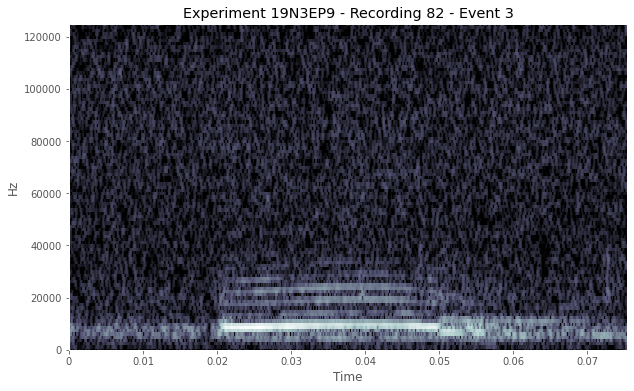

In [7]:
row = next(df[df.apply(lambda r: r.recording == 82 and r.event == 3, axis=1)].iterrows())[1]
fig = plot_stft(row)

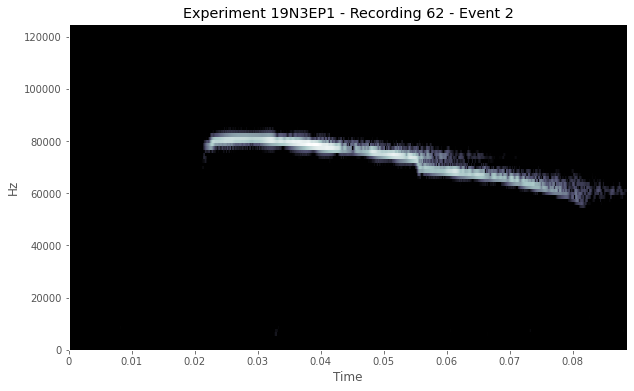

In [8]:
row = next(df[df.apply(lambda r: r.recording == 62 and r.event == 2, axis=1)].iterrows())[1]
fig = plot_stft(row)

## Compute spectrograms and save in folders by clustering

**Retrieve Clustering**

In [9]:
cluster_assigns = pd.read_csv(os.path.join(RESULTS_FOLDER, "cluster_assigns/mean_stft-ward-euclidean.csv"))


MERGE_COLUMNS = ['mother', 'vocalization', 'year', 'nest', 'postnatalday', 'event', 'recording']
clustering = pd.merge(cluster_assigns, df, on=MERGE_COLUMNS, how='inner')
clustering.head()

,vocalization,mother,year,nest,postnatalday,event,recording,clust2,clust3,clust4,clust5,clust6,clust7,clust8,t0,t1,duration,audio_path,experiment
0,1,E,19,E3,1,14,62,2,2,2,3,4,4,5,23.9093,23.9482,0.0389,/media/utilisateur/LACIE SHARE/paloma-USV-data...,19N3EP1
1,1,E,19,E3,1,13,62,1,1,1,2,2,2,2,20.9484,20.9966,0.0482,/media/utilisateur/LACIE SHARE/paloma-USV-data...,19N3EP1
2,1,E,19,E3,1,15,62,2,2,2,3,4,4,5,39.9948,40.0455,0.0507,/media/utilisateur/LACIE SHARE/paloma-USV-data...,19N3EP1
3,1,E,19,E3,1,19,62,2,3,3,4,5,5,6,285.1194,285.1978,0.0784,/media/utilisateur/LACIE SHARE/paloma-USV-data...,19N3EP1
4,1,E,19,E3,1,21,62,2,2,2,3,4,4,5,291.6879,291.7422,0.0543,/media/utilisateur/LACIE SHARE/paloma-USV-data...,19N3EP1


In [10]:
rows = [r for idx, r in clustering.iterrows()]
for row in tqdm(rows[1:2]):

    fig = plot_stft(row)
    
    for n in range(2, 9):
        folder = os.path.join(RESULTS_FOLDER, "fft_images", f"clust{n}", str(row[f'clust{n}']))
        os.makedirs(folder, exist_ok=True)
        figname = f"{row.experiment}_r{row.recording}_e{row.event}.png"
        fig.savefig(os.path.join(folder, figname))
    
    plt.close(fig)

100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


In [11]:
print("FIN ! ")

FIN ! 
